# LAB 4 Bandit Algorithms Experiments

This balance of exploitation, the desire to choose an action which has payed off well in the past, and exploration, the desire to try options which may produce even better results, is what multi-armed bandit algorithms were developed for.

Let’s take a look at several algorithms. The Lab and the lecture do not discuss the mathematics of these algorithms, but link to Python implementations of each of them in the algorithm in the paragraphs below that one can refer to for further details. Same notation for each algorithm are for the select_arm() and update() functions should fully describe the math.

Let set up the library below first

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
#BernoulliTrial
import random
class BernoulliTrial():
    def __init__(self, p):
        self.p = p
        
    def draw(self):
        if random.random() > self.p:
            return 0
        else:
            return 1

In [3]:
#NormalTrial
import random
class NormalTrial():
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
  
    def draw(self):
        return random.gauss(self.mu, self.sigma)

In [4]:
#run_sim
import random
from collections import deque
def run_sim(algorithm, arms, horizon, num_sims=1, terminate=False, confidence=.95, regret=.01, min_trials=1000):
    
    chosen_arms = []
    rewards = []
    cumulative_rewards = []
    sim_nums = []
    trials = []
    alpha = []
    beta = []
    optimal_arm_prob = 0
    potential_value_remaining = 1
    pvr_list = deque([0] * 100)
    previous_idx = 0
    previous_idx_flag = False
    
    for sim in range(num_sims):
        algorithm.reset()
        for t in range(horizon):
            idx = sim * horizon + t
            if previous_idx_flag:
                idx = previous_idx + t
            sim_nums.append(sim)
            trials.append(t)
            
            if 'Thompson' in str(algorithm):
                rhos = algorithm.select_arm().copy()
                if (t > min_trials) and terminate:
                    expected_rewards = [alpha[idx-1][i] / (alpha[idx-1][i] + beta[idx-1][i]) for i in range(len(alpha[idx-1]))]
                    expected_best_arm = expected_rewards.index(max(expected_rewards))
                    theta_max = max(rhos)
                    theta_star = rhos[expected_best_arm]
                    pvr_list.popleft()
                    pvr_list.append((theta_max - theta_star) / theta_star)
                    potential_value_remaining = 0 if sum(pvr_list) == 0 else [i for i in pvr_list if i > 0][-1]
                    if potential_value_remaining < regret:
                        optimal_arm_prob = probability_of_expected_best_arm(algorithm, expected_best_arm)
                        if optimal_arm_prob > confidence:
                            previous_idx_flag = True
                            previous_idx = idx - 1
                            break
                chosen_arm = random.choice([i for i, v in enumerate(rhos) if v == max(rhos)])

            else:
                chosen_arm = algorithm.select_arm()
            chosen_arms.append(chosen_arm)
            reward = arms[chosen_arm].draw()
            rewards.append(reward)
            alpha.append(algorithm.alpha.copy())
            beta.append(algorithm.beta.copy())
            if t == 0:
                cumulative_rewards.append(reward)
            else:
                cumulative_rewards.append(cumulative_rewards[idx - 1] + reward)
            algorithm.update(chosen_arm, reward)
            if t == horizon - 1:
                previous_idx_flag = False
    
#         if 'Thompson' in str(algorithm):
#             if terminate:
#                 if t + 2 <= horizon:
#                     print('The experiment ended after {} trials'.format(t + 1))
#                 else:
#                     print('The experiment ended at the horizon')
#                 print('Optimal arm probability: {}'.format(optimal_arm_prob))
#                 print('Potential value remaining: {}'.format(potential_value_remaining))
    
    return sim_nums, trials, chosen_arms, rewards, cumulative_rewards, alpha, beta

def probability_of_expected_best_arm(algorithm, expected_best_arm):
    count = 0
    count_best_arm = 0
    prob_new = 2
    prob = 0
    while count < 1000:
        if count > 100:
            if abs(prob_new - prob) < .001:
                return prob_new
        count +=1
        prob = prob_new
        rhos = algorithm.select_arm().copy()
        chosen_arm = random.choice([i for i, v in enumerate(rhos) if v == max(rhos)])
        if chosen_arm == expected_best_arm:
            count_best_arm += 1
        prob_new = count_best_arm / count
    return prob_new


In [7]:
from algorithms.plot_functions import format_results, \
                                                summarize_results, \
                                                create_arm_results, \
                                                plot_accuracy, \
                                                plot_performance, \
                                                plot_arms, \
                                                plot_cumulative_reward, \
                                                plot_expected_reward, \
                                                plot_beta_dist, \
                                                plot_beta_grid,\
                                                create_gif, \
                                                geomspace_indices

In [6]:
from algorithms.epsilon_greedy import EpsilonGreedy
from algorithms.epsilon_greedy_annealing import EpsilonGreedyAnnealing
from algorithms.hedge import Hedge
from algorithms.softmax import Softmax
from algorithms.softmax_annealing import SoftmaxAnnealing
from algorithms.ucb1 import UCB1
from algorithms.ucb2 import UCB2
from algorithms.exp3 import EXP3
from algorithms.thompson_sampling import ThompsonSampling
%matplotlib inline
plt.style.use('fivethirtyeight')
mpl.rcParams['lines.linewidth'] = 2

The probility below decide the random of the experiement and uncertainty environment

In [7]:
probabilities = [0, .1, .25, .5, .75, .9]

SET UP the arm to be the best

In [8]:
n_arms = len(probabilities)
random.shuffle(probabilities)
arms = [BernoulliTrial(mu) for mu in probabilities]
print('Best arm is {}'.format(np.argmax(probabilities)))

Best arm is 3


In [9]:
horizon = 250
number_of_simulations = 5000

In [10]:
columns = ['sim_num', 'trial', 'chosen_arm', 'reward', 'cumulative_reward']
columns.extend(['arm_{}'.format(arm) for arm in range(len(arms))])
columns.extend(['arm_{}_cumulative'.format(arm) for arm in range(len(arms))])
df = pd.DataFrame(columns=columns, dtype=float)

In [11]:
grid_size = 4
frame_count = 100

## Epsilon Greedy

In [12]:
data = df.copy()
for epsilon in [0, .1, .2, .3, .4, .5]:
    algorithm = EpsilonGreedy(epsilon, n_arms)
    results = run_sim(algorithm, arms, horizon, number_of_simulations)
    new_rows = format_results(results, arms)
    new_rows['epsilon'] = epsilon
    data = data.append(new_rows, ignore_index=True, sort=False)
df_ave = summarize_results(data, arms, ['epsilon'])

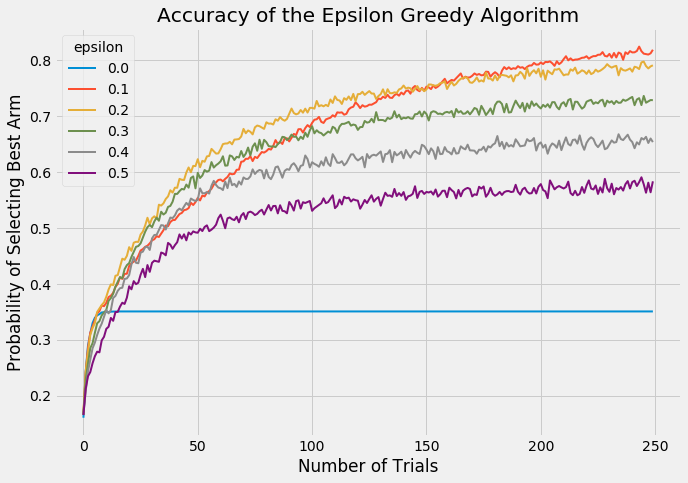

In [13]:
plot_accuracy(df_ave, probabilities, 'Epsilon Greedy', 'epsilon')

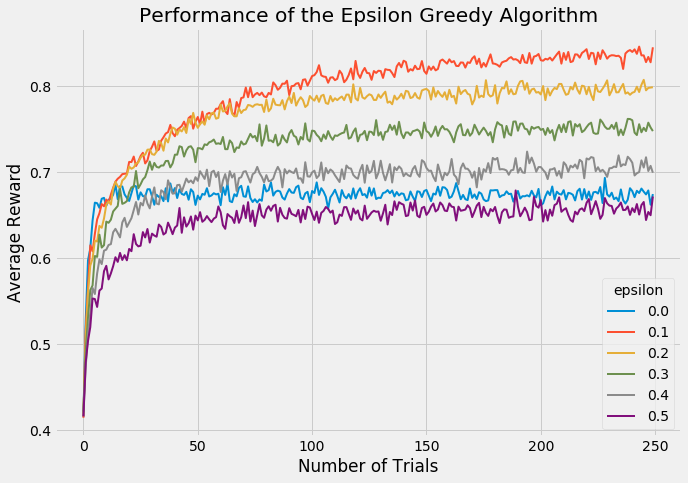

In [14]:
plot_performance(df_ave, 'Epsilon Greedy', 'epsilon')

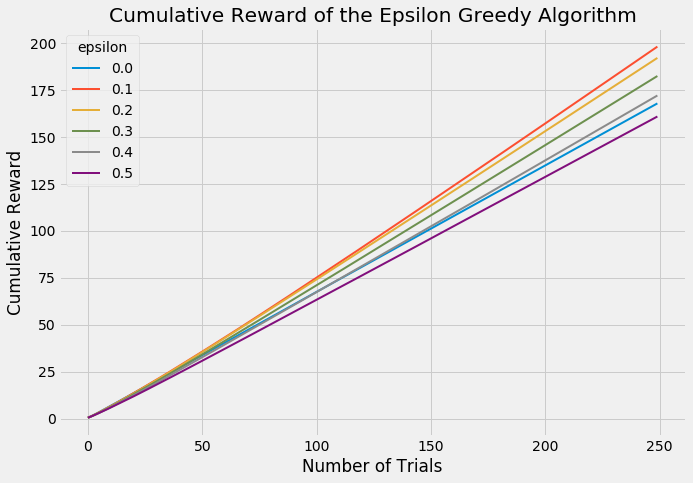

In [15]:
plot_cumulative_reward(df_ave, 'Epsilon Greedy', 'epsilon')

/Users/victorius/Desktop/bandits-master/multi_armed_bandit-master/simulation_framework/plot_functions.py:212: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  fig.legend(handles, labels, loc='best')


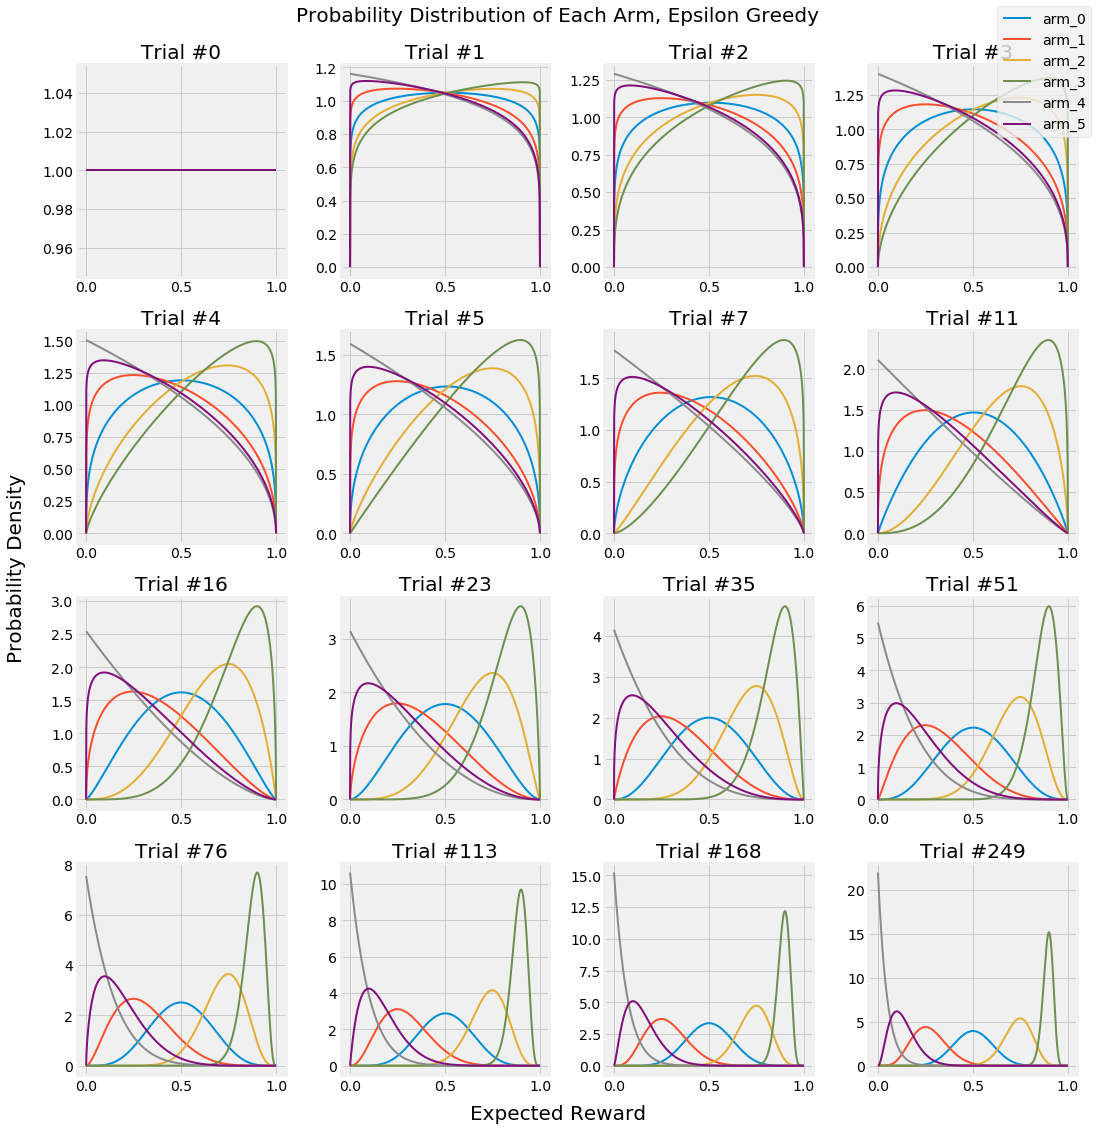

In [16]:
df_ave = df_ave[df_ave['epsilon'] == .5]

plot_beta_grid(df_ave, probabilities, 'Epsilon Greedy', horizon, grid_size)

In [25]:
df_ave = df_ave[df_ave['annealing_factor'] == .0000001]
plot_beta_grid(df_ave, probabilities, 'Epsilon Greedy', horizon, grid_size)

KeyError: 'annealing_factor'

## Traditional A/B test
Does treatment B outperform by 5% the current state, A (with historically known reward), at the 95% confidence level?

In [17]:
prob_a = .01  # In reality, true value unknown. Needed for simulation.
prob_b = prob_a * 1.05  # In reality, true value unknown. Needed for simulation.
alpha = .05

### Use Power Analysis to determine required sample size

In [18]:
beta = .8  # Power required

trial_a = BernoulliTrial(prob_a)
historical_data = [trial_a.draw() for idx in range(100000000)]
st_dev = np.std(historical_data)
print('historical mean reward: {}'.format(np.mean(historical_data)))

z_alpha = stats.norm.ppf(alpha / 2)
z_beta = stats.norm.ppf(beta)

sample_size = 2 * st_dev ** 2 * (np.abs(z_alpha) + np.abs(z_beta)) ** 2 / (prob_b - np.mean(historical_data)) ** 2
sample_size

# alternate sample size calculation
sample_size2 = (np.mean(historical_data) * (1 - np.mean(historical_data)) + prob_b * (1 - prob_b)) / \
               (prob_b - np.mean(historical_data))**2 * (z_alpha + z_beta)**2
sample_size2

historical mean reward: 0.01000841


105050.19081860832

### Simulate A/B test

In [19]:
from math import log10, ceil, floor

def round_up(x, sigfigs=1):
    exponent = floor(log10(x))
    mantissa = x/10**exponent
    mantissa = ceil(mantissa * 10**(sigfigs-1)) / 10**(sigfigs-1)
    return mantissa * 10**exponent

In [21]:
horizon = int(round_up(sample_size))  # round up necessary sample size
trial_b = BernoulliTrial(prob_b)
results_a = np.array([trial_a.draw() for idx in range(horizon)])
results_b = np.array([trial_b.draw() for idx in range(horizon)])

t=-1.064, p=0.287
The p-value is not less than the confidence level. Accept null hypothesis that the means are equal.


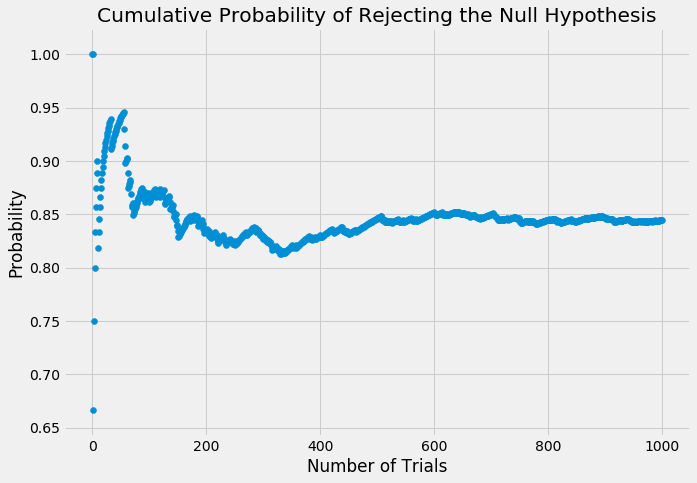

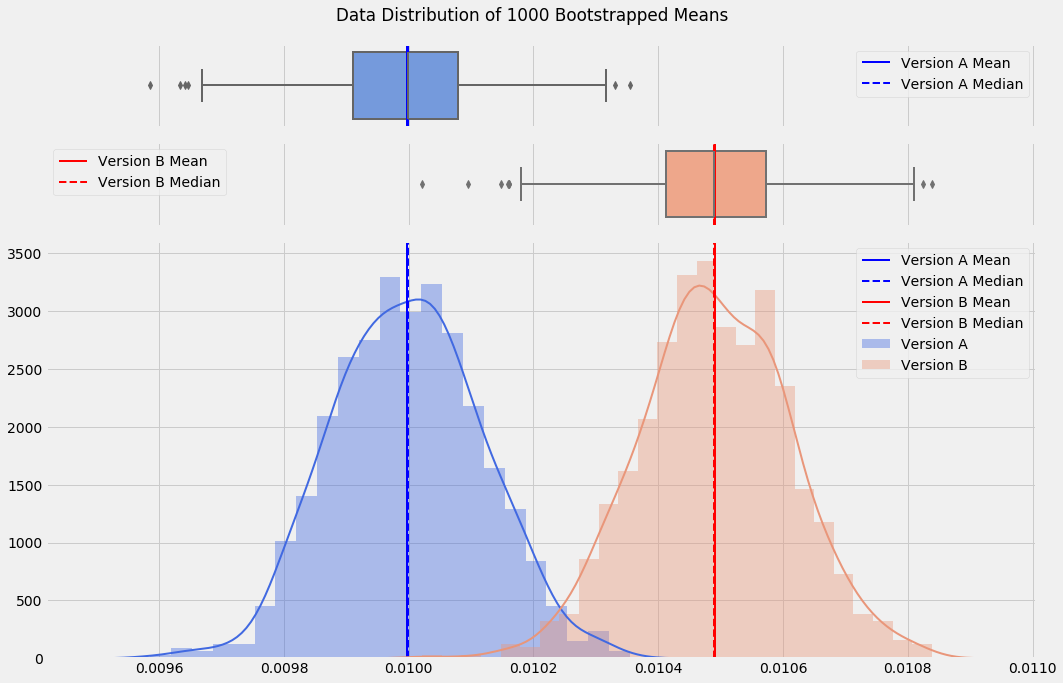

In [23]:
stat, p = stats.ttest_ind(results_a, results_b)
print('t={:.3f}, p={:.3f}'.format(stat, p))

# interpret via p-value
if p > alpha:
    print('The p-value is not less than the confidence level. Accept null hypothesis that the means are equal.')
else:
    print('The p-value is less than the confidence level. Reject the null hypothesis that the means are equal.')

# Find average result of 1000 sims
num_sims = 1000

results = []

for i in range(num_sims):
    results_a = np.array([trial_a.draw() for idx in range(horizon)])
    results_b = np.array([trial_b.draw() for idx in range(horizon)])
    stat, p = stats.ttest_ind(results_a, results_b)
    if p > .05:
        results.append(0)
    else:
        results.append(1)
sum(results) / len(results)

df = pd.DataFrame({'results': results})
df['cumsum'] = df['results'].cumsum()
df['average'] = df['cumsum'] / (df.index + 1)
plt.figure(figsize=(10, 7))
plt.scatter(df.index, df['average'])
plt.xlabel('Number of Trials')
plt.ylabel('Probability')
plt.title('Cumulative Probability of Rejecting the Null Hypothesis')
plt.show()

bootstrapped_samples = 1000

results_a = np.mean([np.array([trial_a.draw() for idx in range(bootstrapped_samples)]) for i in range(horizon)], axis=0)
results_b = np.mean([np.array([trial_b.draw() for idx in range(bootstrapped_samples)]) for i in range(horizon)], axis=0)

mean_a = np.mean(results_a)
median_a = np.median(results_a)
mean_b = np.mean(results_b)
median_b = np.median(results_b)

fig, (ax_box_a, ax_box_b, ax_hist) = plt.subplots(3, sharex=True, gridspec_kw= {"height_ratios": (0.2, 0.2, 1)}, figsize=(15, 10))

sns.boxplot(results_a, ax=ax_box_a, color='cornflowerblue')
ax_box_a.axvline(mean_a, color='b', linestyle='-', label='Version A Mean')
ax_box_a.axvline(median_a, color='b', linestyle='--', label='Version A Median')
ax_box_a.legend()
ax_box_a.set(xlabel='')

sns.boxplot(results_b, ax=ax_box_b, color='lightsalmon')
ax_box_b.axvline(mean_b, color='r', linestyle='-', label='Version B Mean')
ax_box_b.axvline(median_b, color='r', linestyle='--', label='Version B Median')
ax_box_b.legend()
ax_box_b.set(xlabel='')

sns.distplot(results_a, color='royalblue', label='Version A')
plt.axvline(mean_a, color='b', linestyle='-', label='Version A Mean')
plt.axvline(median_a, color='b', linestyle='--', label='Version A Median')

sns.distplot(results_b, color='darksalmon', label='Version B')
plt.axvline(mean_b, color='r', linestyle='-', label='Version B Mean')
plt.axvline(median_b, color='r', linestyle='--', label='Version B Median')
ax_hist.set(xlabel='')

plt.legend()

fig.suptitle('Data Distribution of 1000 Bootstrapped Means')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()